In [1]:
import numpy as np
from einops import rearrange

from utils import *

from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn.metrics.pairwise import cosine_similarity

import os

In [2]:
 # HARDCODED FOR LLAVA
num_heads_llm = 40
num_layers_llm = 40

In [3]:
base_dir = 'features_bias_2/train'
val_ratio = 0.2
n_samples = 200

In [5]:
# head_truth_llm = np.load(f"{base_dir}/truth/head_wise_{n_samples}_llm.npy")
# head_truth_llm = rearrange(head_truth_llm, 'b l (h d) -> b l h d', h = num_heads_llm)
# print('truth', head_truth_llm.shape)
head_bias_llm = np.load(f"{base_dir}/bias/head_wise_{n_samples}_llm.npy")
head_bias_llm = rearrange(head_bias_llm, 'b l (h d) -> b l h d', h = num_heads_llm)
print('bias', head_bias_llm.shape)

# labels_truth = np.load(f"{base_dir}/truth/labels_{n_samples}.npy")
labels_bias = np.load(f"{base_dir}/bias/labels_{n_samples}.npy")
# labels_bias = [0 for i in range(len(labels_bias))]
print(np.unique(labels_bias))

bias (798, 40, 40, 128)
[1 2 3 4 5]


## Lets analyze the accuracy

In [6]:
def get_performance_dict(X, y, num_layers, num_heads):
    head_perf_dict = {f'l{l}_h{h}': [] for l in range(num_layers) for h in range(num_heads)}
    for l in tqdm(range(num_layers)):
        for h in range(num_heads):
            X_probe = X[:, l, h, :]
            y_probe = y[:]
            _, val_acc = train_single_prob(X_probe, y_probe, val_size=val_ratio)
            head_perf_dict[f'l{l}_h{h}'] = val_acc
    return head_perf_dict

In [12]:
def get_perf_array(X_all, y_all, num_layers, num_heads):
    head_perf_dict = get_performance_dict(X_all, y_all, num_layers, num_heads)
    l_h_means = np.array(list(head_perf_dict.values())).reshape(num_layers, num_heads) # row = heads | colums = layers
    return l_h_means

In [23]:
# perf_all = []
# for bias_label in np.unique(labels_bias):
#     X_bias = head_bias_llm[np.argwhere(labels_bias==bias_label).flatten(), :, :, :]
#     print(bias_label, len(X_bias))
#     y_bias = [1 for i in range(len(X_bias))]
#     X_all_llm = np.vstack((head_truth_llm, X_bias))
#     y_all = np.hstack((labels_truth, y_bias))
#     llm_perf = get_perf_array(X_all_llm, y_all, num_layers_llm, num_heads_llm)
#     perf_all.append(llm_perf)

In [ ]:
fix, axs = plt.subplots(1, len(perf_all), figsize=(13,5))
orig_map=plt.cm.get_cmap('viridis') 
reversed_map = orig_map.reversed() 

im_all = []
for i in range(len(perf_all)):
    im = axs[i].imshow(perf_all[i], cmap = reversed_map)
    im_all.append(im)
    axs[i].set_title(i+2)
for i,im in enumerate(im_all):
    plt.colorbar(im,ax=axs[i])
plt.xlabel('# head')
plt.ylabel('# layer')
plt.show()

In [ ]:
orig_map=plt.cm.get_cmap('viridis') 
reversed_map = orig_map.reversed() 
plt.imshow(np.mean(perf_all, axis=0), cmap=reversed_map)
plt.colorbar()
plt.title('mean over all')
plt.show()

In [19]:
X_all = head_bias_llm
y_all = np.array(labels_bias)
y_all = y_all-1

In [20]:
np.unique(y_all)

array([0, 1, 2, 3, 4])

In [21]:
multiclass_perf = get_perf_array(X_all, y_all, num_layers_llm, num_heads_llm)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:31<00:00,  2.28s/it]


/tmp/ipykernel_788244/1893101339.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plt.cm.get_cmap('viridis')


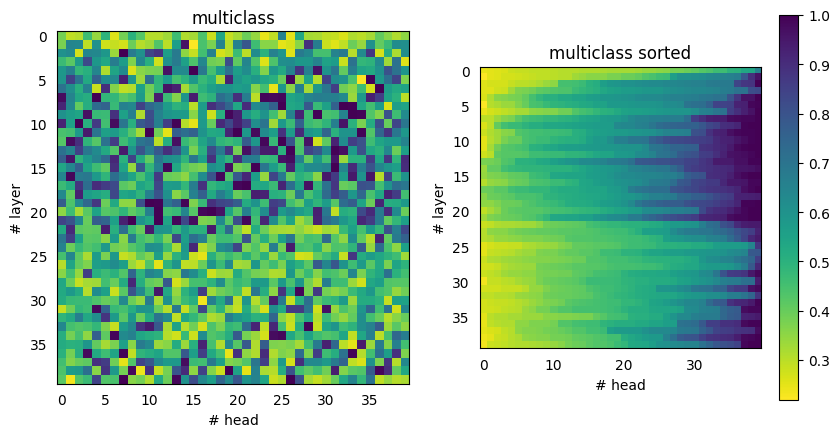

In [22]:
fix, axs = plt.subplots(1, 2, figsize=(10,5))
orig_map=plt.cm.get_cmap('viridis') 
reversed_map = orig_map.reversed() 
axs[0].imshow(multiclass_perf, cmap=reversed_map)
sorted_arr = np.copy(multiclass_perf)
sorted_arr.sort(axis=1)
im1=axs[1].imshow(sorted_arr, cmap=reversed_map)
axs[0].set_title('multiclass')
axs[1].set_title('multiclass sorted')

plt.colorbar(im1,ax=axs[1])
axs[0].set_xlabel('# head')
axs[0].set_ylabel('# layer')
axs[1].set_xlabel('# head')
axs[1].set_ylabel('# layer')
axs[0].tick_params(left=False, bottom=False)
axs[1].tick_params(left=False, bottom=False)
plt.show()